In [35]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [36]:
MASTER = Path("../data/processed/master_teams_2000_2019.csv")
TAB_OUT = Path("../data/processed")
FIG_OUT = Path("../plots")
TAB_OUT.mkdir(parents=True, exist_ok=True)
FIG_OUT.mkdir(parents=True, exist_ok=True)
LATEX_OUT = Path("../latex/tables")
LATEX_OUT.mkdir(parents=True, exist_ok=True)

In [37]:
df = pd.read_csv(MASTER, parse_dates=["season_date"])

In [38]:
BEST_FORMULA = "W ~ RunDiff + I(RunDiff**2)"
BASELINE_FORMULAS = {
    "RunDiff (lineal)": "W ~ RunDiff",
    "ERA (lineal)": "W ~ ERA",
    "HR (lineal)": "W ~ HR",
}

In [39]:
train_mask = (df["yearID"] >= 2000) & (df["yearID"] <= 2016)
test_mask = (df["yearID"] >= 2017) & (df["yearID"] <= 2019)

In [40]:
df_train = df.loc[train_mask].copy()
df_test = df.loc[test_mask].copy()

In [41]:
print(df_train["yearID"].min(), df_train["yearID"].max(), len(df_train))
print(df_test["yearID"].min(), df_test["yearID"].max(), len(df_test))

2000 2016 510
2017 2019 90


In [42]:
best_mod = smf.ols(BEST_FORMULA, data=df_train).fit()
print(best_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1742.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):          6.84e-228
Time:                        00:07:38   Log-Likelihood:                -1436.6
No. Observations:                 510   AIC:                             2879.
Df Residuals:                     507   BIC:                             2892.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          81.1347      0.231    3

In [43]:
pred_train = best_mod.get_prediction(df_train)
pred_train_df = pred_train.summary_frame(alpha=0.05)

In [ ]:
df_train_pred = df_train.copy()
df_train_pred["yhat"] = pred_train_df["mean"].values
df_train_pred["mean_ci_low"] = pred_train_df["mean_ci_lower"].values
df_train_pred["mean_ci_high"] = pred_train_df["mean_ci_upper"].values
df_train_pred["pred_ci_low"] = pred_train_df["obs_ci_lower"].values
df_train_pred["pred_ci_high"] = pred_train_df["obs_ci_upper"].values

In [ ]:
pred_test = best_mod.get_prediction(df_test)
pred_test_df = pred_test.summary_frame(alpha=0.05)
df_test_pred = df_test.copy()
df_test_pred["yhat"] = pred_test_df["mean"].values
df_test_pred["mean_ci_low"] = pred_test_df["mean_ci_lower"].values
df_test_pred["mean_ci_high"] = pred_test_df["mean_ci_upper"].values
df_test_pred["pred_ci_low"] = pred_test_df["obs_ci_lower"].values
df_test_pred["pred_ci_high"] = pred_test_df["obs_ci_upper"].values

In [46]:
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [47]:
mse_tr, rmse_tr, mae_tr = metrics(df_train_pred["W"], df_train_pred["yhat"])
mse_te, rmse_te, mae_te = metrics(df_test_pred["W"], df_test_pred["yhat"])

In [48]:
eval_rows = [
    {
        "Modelo": "Best: " + BEST_FORMULA,
        "Split": "Train (2000–2016)",
        "MSE": mse_tr,
        "RMSE": rmse_tr,
        "MAE": mae_tr,
        "N": len(df_train_pred),
    },
    {
        "Modelo": "Best: " + BEST_FORMULA,
        "Split": "Test (2017–2019)",
        "MSE": mse_te,
        "RMSE": rmse_te,
        "MAE": mae_te,
        "N": len(df_test_pred),
    },
]

In [49]:
for name, fml in BASELINE_FORMULAS.items():
    mod = smf.ols(fml, data=df_train).fit()
    yhat_tr = mod.predict(df_train)
    yhat_te = mod.predict(df_test)
    mse_tr, rmse_tr, mae_tr = metrics(df_train["W"], yhat_tr)
    mse_te, rmse_te, mae_te = metrics(df_test["W"], yhat_te)
    eval_rows.append(
        {
            "Modelo": name,
            "Split": "Train (2000–2016)",
            "MSE": mse_tr,
            "RMSE": rmse_tr,
            "MAE": mae_tr,
            "N": len(df_train),
        }
    )
    eval_rows.append(
        {
            "Modelo": name,
            "Split": "Test (2017–2019)",
            "MSE": mse_te,
            "RMSE": rmse_te,
            "MAE": mae_te,
            "N": len(df_test),
        }
    )

eval_df = pd.DataFrame(eval_rows)
eval_df.to_csv(TAB_OUT / "forecast_eval_metrics.csv", index=False, float_format="%.6f")
print(eval_df)

                              Modelo              Split         MSE  \
0  Best: W ~ RunDiff + I(RunDiff**2)  Train (2000–2016)   16.374961   
1  Best: W ~ RunDiff + I(RunDiff**2)   Test (2017–2019)   15.103704   
2                   RunDiff (lineal)  Train (2000–2016)   16.419602   
3                   RunDiff (lineal)   Test (2017–2019)   15.570596   
4                       ERA (lineal)  Train (2000–2016)   78.792363   
5                       ERA (lineal)   Test (2017–2019)   83.491520   
6                        HR (lineal)  Train (2000–2016)  109.491126   
7                        HR (lineal)   Test (2017–2019)  165.823211   

        RMSE        MAE    N  
0   4.046599   3.243940  510  
1   3.886348   2.937251   90  
2   4.052111   3.251917  510  
3   3.945959   2.977856   90  
4   8.876506   7.176658  510  
5   9.137369   7.209467   90  
6  10.463801   8.630158  510  
7  12.877236  10.449960   90  


In [50]:
try:
    with open(LATEX_OUT / "forecast_eval_metrics.tex", "w") as f:
        f.write(
            eval_df.rename(
                columns={
                    "Modelo": "Modelo",
                    "Split": "Partición",
                    "MSE": "MSE",
                    "RMSE": "RMSE",
                    "MAE": "MAE",
                    "N": "N",
                }
            ).to_latex(
                index=False,
                float_format="%.3f",
                caption="Evaluación de pronóstico (train/test temporal)",
                label="tab:forecast_eval",
            )
        )
    print(f"Tabla LaTeX exportada: {LATEX_OUT / 'forecast_eval_metrics.tex'}")
except Exception as e:
    print("No se exportó LaTeX (opcional). Razón:", e)

Tabla LaTeX exportada: ../latex/tables/forecast_eval_metrics.tex


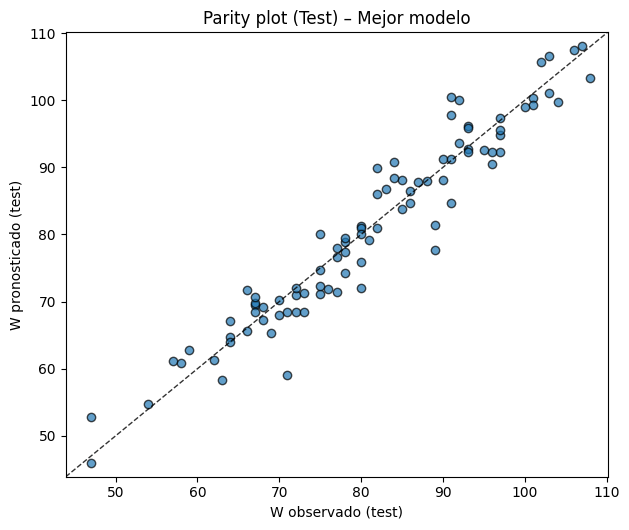

In [52]:
plt.figure(figsize=(6.4, 5.4))
plt.scatter(df_test_pred["W"], df_test_pred["yhat"], alpha=0.7, edgecolor="black")
lims = [
    min(df_test_pred["W"].min(), df_test_pred["yhat"].min()) - 2,
    max(df_test_pred["W"].max(), df_test_pred["yhat"].max()) + 2,
]
plt.plot(lims, lims, "k--", lw=1, alpha=0.8)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("W observado (test)")
plt.ylabel("W pronosticado (test)")
plt.title("Parity plot (Test) – Mejor modelo")
plt.tight_layout()
plt.savefig(
    FIG_OUT / "forecast_parity_test_best.png",
    dpi=150,
    bbox_inches="tight",
    transparent=True,
)
plt.show()
plt.close()

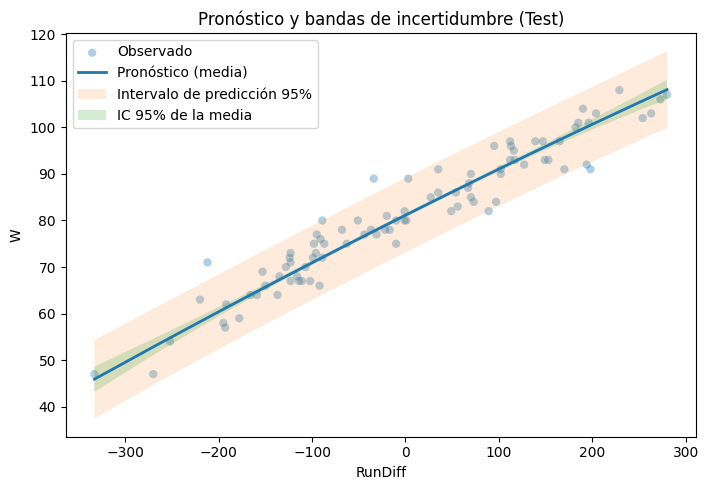

In [54]:
tmp = df_test_pred.sort_values("RunDiff")
plt.figure(figsize=(7.2, 5.0))
plt.scatter(tmp["RunDiff"], tmp["W"], alpha=0.35, label="Observado", edgecolor="none")
plt.plot(tmp["RunDiff"], tmp["yhat"], lw=2, label="Pronóstico (media)")
plt.fill_between(
    tmp["RunDiff"],
    tmp["pred_ci_low"],
    tmp["pred_ci_high"],
    alpha=0.15,
    label="Intervalo de predicción 95%",
)
plt.fill_between(
    tmp["RunDiff"],
    tmp["mean_ci_low"],
    tmp["mean_ci_high"],
    alpha=0.20,
    label="IC 95% de la media",
)
plt.xlabel("RunDiff")
plt.ylabel("W")
plt.title("Pronóstico y bandas de incertidumbre (Test)")
plt.legend()
plt.tight_layout()
plt.savefig(
    FIG_OUT / "forecast_intervals_vs_rundiff_test.png",
    dpi=150,
    bbox_inches="tight",
    transparent=True,
)
plt.show()
plt.close()

In [55]:
def forecast_new(best_fitted_model, new_rundiff_list):
    new = pd.DataFrame({"RunDiff": new_rundiff_list})
    pred = best_fitted_model.get_prediction(new)
    sf = pred.summary_frame(alpha=0.05)
    out = new.copy()
    out["yhat"] = sf["mean"].values
    out["mean_ci_low"] = sf["mean_ci_lower"].values
    out["mean_ci_high"] = sf["mean_ci_upper"].values
    out["pred_ci_low"] = sf["obs_ci_lower"].values
    out["pred_ci_high"] = sf["obs_ci_upper"].values
    return out

In [56]:
ejemplo = forecast_new(best_mod, new_rundiff_list=[-150, -50, 0, 50, 150, 250])
print(ejemplo)
ejemplo.to_csv(TAB_OUT / "forecast_new_examples.csv", index=False)

   RunDiff        yhat  mean_ci_low  mean_ci_high  pred_ci_low  pred_ci_high
0     -150   65.692592    65.036592     66.348591    57.692000     73.693184
1      -50   76.064270    75.604390     76.524150    68.077366     84.051173
2        0   81.134705    80.681527     81.587883    73.148185     89.121226
3       50   86.128205    85.690162     86.566247    78.142529     94.113881
4      150   95.884397    95.170854     96.597939    87.878881    103.889912
5      250  105.332845   103.633504    107.032187    97.180122    113.485569
